<a href="https://colab.research.google.com/github/marlapinkert/final_project_compcognition/blob/main/download_and_correlation_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Random Forest Classifier for Autism Spectrum Disorder (ASD)
#### Final Project for TEWA I, supervisors: Dominik Pegler, Mengfan Zhang, Jozsef Arato
*Jannis Breßgott, Sara Binder, Marla Pinkert, 09.07.2024*

Autism spectrum disorder (ASD) is a neurological and developmental disorder which manifests in differences in social communication and interaction, learning, and sensation, with a wide range of associated subjective and objective impairments of quality of life (for review, see Lord et al., 2020). As demonstrated by Ilioska and colleagues in a large-scale analysis of resting-state fMRI data including 1824 individuals (796 with ASD), ASD is characterized by both hypo- and hyperconnectivity (Ilioska et al., 2023). Previous studies attempted to train machine learning models to predict ASD diagnosis based on structural and functional changes in the brain (Chen et al., 2015; Heinsfeld et al., 2018; Yang et al., 2020; Yang et al., 2022), and reached prediction accuracies of 69% (Yang et al., 2022) to 91% (Chen et al., 2015).

Subsequently, we decided to train a random forest model to predict subjects' ASD diagnosis based on functional connectivity, utilizing preprocessed data from the Autism Brain Imaging Data Exchange I (ABIDE I, Craddock et al., 2013). Thus, after excluding 228 subjects due to missing values, we had access to 884 subjects (408 with ASD). We downloaded data preprocessed using the CPAC pipeline (as outlined in http://preprocessed-connectomes-project.org/abide/Pipelines.html), as it previously performed best in classification of functional connectivity in ASD (Yang et al., 2020). Time courses were extracted based on regions of interest (ROIs) defined using the Craddock 200 (CC200) atlas (Craddock et al., 2011). Our data was split randomly in test and training data, with a test data set of 30%.

We decided to test three types of models: (1) a model including all predictors, (2) a model with a reduced number of features using principle-component analysis (PCA), and (3) two models which were based on graph theoretical measures (degree and betweenness centrality) of each individual ROI. For the first two models, we attempted to find optimal parameters through randomized search and only fit the respective model with the best parameters to the test data.

## Import dependencies and download data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from glob import glob
from nilearn import connectome
from nilearn import plotting
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Below function can be used to download the ABIDE 
!python resources/download_abide_preproc.py -d rois_cc200 -p cpac -s filt_global -o output

No upper age threshold specified
No lower age threshold specified
No site specified, using all sites...
No sex specified, using all sexes...
b',Unnamed: 0,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,FIQ_TEST_TYPE,VIQ_TEST_TYPE,PIQ_TEST_TYPE,ADI_R_SOCIAL_TOTAL_A,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_ONSET_TOTAL_D,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,ADOS_STEREO_BEHAV,ADOS_RSRCH_RELIABLE,ADOS_GOTHAM_SOCAFFECT,ADOS_GOTHAM_RRB,ADOS_GOTHAM_TOTAL,ADOS_GOTHAM_SEVERITY,SRS_VERSION,SRS_RAW_TOTAL,SRS_AWARENESS,SRS_COGNITION,SRS_COMMUNICATION,SRS_MOTIVATION,SRS_MANNERISMS,SCQ_TOTAL,AQ_TOTAL,COMORBIDITY,CURRENT_MED_STATUS,MEDICATION_NAME,OFF_STIMULANTS_AT_SCAN,VINELAND_RECEPTIVE_V_SCALED,VINELAND_EXPRESSIVE_V_SCALED,VINELAND_WRITTEN_V_SCALED,VINELAND_COMMUNICATION_STANDARD,VINELAND_PERSONAL_V_SCALED,VINELAND_DOMESTIC_V_SCALED,VINELAND_COMMUNITY_V_SCALED,VINELAND_DAILYLVNG_STANDARD,VINELAND_

In [2]:
# We read in the phenotype dataframe and create a new df with only diagnoses
# The Phenotypic_V1_0b_preprocessed1.csv can be downloaded from http://preprocessed-connectomes-project.org/abide/download.html
pheno_df = pd.read_csv("Phenotypic_V1_0b_preprocessed1.csv", index_col = 0)
diagnose_df = pheno_df.loc[:,["FILE_ID", "DX_GROUP", "DSM_IV_TR"]]

In [3]:
# We list the paths for each subject using glob
subj_paths = sorted(glob("cpac/filt_global/rois_cc200/*.1D"))

## Model 1: Functional Connectivity, all Predictors

For our first model, we followed an approach already attempted by Chen et al. (2015), who trained a random forest classifier on the ABIDE data and utlized individual correlations between all ROIs as predictors without employing any kinds of dimensionality reduction techniques. Our procedure was the following: 
1. Calculate connectivity matrices using time courses of our 200 ROIs.
2. Vectorize connectivity matrices while only keeping individual correlations, resulting in 19900 predictors.
3. Repeat first two steps for all subjects to create a DataFrame with rows corresponding to subjects and columns to correlations.

### Prepare Data

In [58]:
# Define Class which gets dict of unique correlations for one subject
class UniqueCorrelations:
    '''
        Parameters:
            - time_course_path: path to a 1D file containing timecourses of all relevant regions
              for one specific subject
            - correlation_kind: {"covariance", "correlation", "partial correlation", "tangent", "precision"}, 
              default="correlation"
              Kind of correlation to calcualte, takes same arguments as nilearn.connectome.ConnectivityMeasure()
            - subject_ID: whether "FILE_ID" should be added to dict, default = True
    '''
    
    def __init__(self, correlation_kind, time_course_path, subject_ID=True):

        self.correlation_kind = correlation_kind
        self.time_course_path = time_course_path
        self.subject_ID = subject_ID
    
    def get_corr_list(self):
    
        '''          
        Creates: self.unique_corrs, self.connectivity_matrix
        - unique corrs: dictionnary with unique correlations between timecourses,
          keys corresponding to correlation of two timeseries 
          e.g.: key '0x4' corresponds to correlation of regions 0 and 4.
        - connectivity matrix: connectivity matrix for all timeseries for one subjects.
          can be used to be plotted with nilearn.plotting.plot_matrix()
        '''

        # read the file into a DataFrame
        df = pd.read_csv(self.time_course_path, sep="\t")
        df = np.array(df)
        
        # calculate corr matrix for DataFrame (all rois)
        correlation_measure = connectome.ConnectivityMeasure(
            kind=self.correlation_kind
        )
        
        connectivity_matrix = correlation_measure.fit_transform([df])[0]
        corrs = pd.DataFrame(connectivity_matrix)
    
        # create index with only unique combinations of row x column
        # this ensures we get an index which only gets us the "lower half"
        # of the correlation matrix
        rois_numbers = np.linspace(0, (len(corrs)-1), len(corrs), dtype = "int")
        comb_ind = [comb for comb in combinations(rois_numbers, 2)]
    
        # use new index to select only the unique combinations from our DataFrame
        # we save this as a dictionnary with the combination of values as keys
        # I.e., correlation of region 1 and region 4 is called "1x4"
        unique_corrs = {}
        for ind in comb_ind:
           unique_corrs[f"{ind[0]}x{ind[1]}"] = corrs.iloc[ind]
    
        # We add the name of the file as "ID" to the dictionnary. This allows us to later identify 
        # the subjects when we create our DataFrame with all our subjects
        subject_id = self.time_course_path.split("\\")[-1].split("_rois")[0]
        unique_corrs["FILE_ID"] = subject_id   

        self.unique_corrs = unique_corrs
        self.connectivity_matrix = connectivity_matrix
        

In [ ]:
# Create DataFrame with all subjects
list_unique_corrs = []
for path in subj_paths:
    get_unique_corr = UniqueCorrelations("correlation", path)
    get_unique_corr.get_corr_list()
    list_unique_corrs.append(get_unique_corr.unique_corrs)

corr_df = pd.DataFrame(list_unique_corrs)
corr_df.to_csv("corr_df2.csv")

### Model 1.a. Baseline Parameters
First, we used the baseline parameters of sklearn to train a random forest classifier. We used 5-fold cross validation and the out-of-the-bag (OOB) score to evaluate performance of this baseline model.

In [18]:
# Do this to avoid running cells above
#corr_df = pd.read_csv("corr_df2.csv", index_col = 0)

In [20]:
# We merge our df with the diagnoses with our predictor df based on file id

corr_merged_df = pd.merge(corr_df, diagnose_df, on = "FILE_ID", how = "left")
corr_merged_df = corr_merged_df.dropna()

In [21]:
corr_merged_df

,0x1,0x2,0x3,0x4,0x5,0x6,0x7,0x8,0x9,0x10,...,195x199,196x197,196x198,196x199,197x198,197x199,198x199,FILE_ID,DX_GROUP,DSM_IV_TR
0,-0.021467,-0.187501,-0.110207,-0.139796,-0.140914,-0.040939,-0.110999,-0.067757,-0.154264,0.108708,...,0.266195,-0.226139,0.018427,0.004807,0.265858,0.054465,-0.050270,CMU_a_0050649,1,1
1,0.095538,0.058648,-0.122837,0.020233,-0.206860,-0.086722,0.060630,0.080113,-0.170965,0.263906,...,-0.051347,0.000000,0.001161,-0.048704,0.000000,0.000000,0.278666,CMU_a_0050653,1,1
2,-0.101705,0.169398,-0.088469,-0.283181,0.061635,-0.509001,0.234423,-0.294858,0.000000,-0.001364,...,-0.126286,0.000000,0.150341,0.208479,0.000000,0.000000,-0.242953,CMU_b_0050651,1,1
3,-0.308470,-0.032817,-0.135309,-0.417513,0.053874,-0.361935,0.312277,-0.147749,-0.252594,-0.344279,...,0.165728,-0.225255,-0.056809,-0.024379,0.168549,-0.028447,-0.273653,CMU_b_0050657,2,0
4,-0.253479,-0.212435,-0.057959,-0.132481,0.259912,-0.034246,0.164835,0.138874,0.004467,-0.070075,...,0.274862,-0.062590,-0.201054,-0.133704,-0.024035,0.071136,0.055127,CMU_b_0050669,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,-0.088498,-0.154708,0.059148,-0.076943,0.034965,-0.035397,0.226933,0.013525,-0.056600,-0.143671,...,0.180841,-0.178419,-0.100331,0.133203,0.225497,0.025105,0.172720,Yale_0050624,1,3
880,-0.100814,0.066965,-0.135872,-0.326887,0.171688,-0.479613,0.418145,0.081435,-0.015165,-0.152164,...,0.073530,-0.062367,-0.008525,0.317559,0.098184,0.320357,-0.048426,Yale_0050625,1,3
881,-0.101209,-0.228416,-0.111852,-0.106471,0.045378,0.122418,0.198656,0.023379,0.021482,0.102916,...,0.018232,-0.042133,-0.243732,-0.178639,0.232233,0.185407,0.144847,Yale_0050626,1,3
882,-0.198637,0.280778,-0.202204,-0.050013,-0.013214,-0.112091,0.034506,0.190940,-0.125901,-0.191852,...,0.008584,-0.060364,-0.035339,0.125434,0.105161,-0.069113,0.018606,Yale_0050627,1,3


In [22]:
# We split our data into predictor and outcome
X = corr_merged_df.drop(["FILE_ID", "DX_GROUP", "DSM_IV_TR"], axis=1)
y = corr_merged_df["DX_GROUP"]

# We split data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Initialize basic rf
rf = RandomForestClassifier(oob_score=True)

# Fit rf to training data
rf.fit(X_train, y_train)

# Calculate cross validation score
rf_cross_val = cross_val_score(rf, X_train, y_train, cv=5)

# We calculate the cross validated predictions. This is not used for
# evaluation of the model but for visualization of confusion matrices.
rf_cross_val_pred = cross_val_predict(rf, X_train, y_train, cv=5) 
matrix_pred = confusion_matrix(y_train, rf_cross_val_pred)
matrix_pred = matrix_pred.astype('float') / matrix_pred.sum(axis=1)[:, np.newaxis]

In [25]:
print(f"This model has an OOB score of {rf.oob_score_}")
print(f"The mean cross validation score was {rf_cross_val.mean()}")
print(f"The standard deviation of our cross validation was {rf_cross_val.std()}")

This model has an OOB score of 0.6084142394822006
The mean cross validation score was 0.6586414896407029
The standard deviation of our cross validation was 0.032948977155345234


In [26]:
matrix_pred

array([[0.59797297, 0.40202703],
       [0.29503106, 0.70496894]])

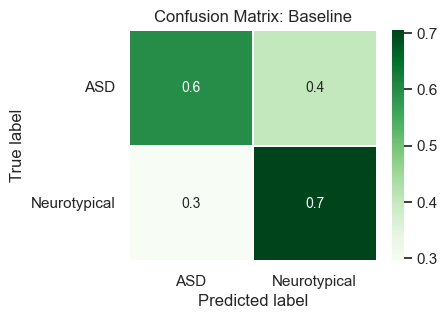

In [28]:
# plot the confusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(matrix_pred, annot=matrix_pred, annot_kws={'size':10},
            cmap=plt.cm.Greens, 
            linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: Baseline')

plt.show()


### Model 1.b. Hyperparameter Tuning

In order to improve the model, we employed randomized search to find the best parameters for our model. As we were able to achieve higher accuracy than within our baseline model, we discarded the baseline model. Thus, for Model 1, we only fit Model 1.b. to the test data. 

In [62]:
# first, we define hyperparameters we want to test.

# number of trees in random forest
n_estimators = [10, 20, 50, 100, 200] 

# number of features to consider at every split
max_features = [0.25, 0.5, 0.75, 1.0, 'sqrt']

# naximum number of levels in tree
max_depth = [3, 5, 7]
max_depth.append(None)

# ninimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# ninimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 20, 50, 100, 200], 'max_features': [0.25, 0.5, 0.75, 1.0, 'sqrt'], 'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [63]:
# random search of parameters, using 3 fold cross validation 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf_random.fit(X_train, y_train)

random_results = pd.DataFrame(rf_random.cv_results_) # "accuracy" and training score
print(f"Best parameters for model: {rf_random.best_params_}") # parameter setting that gave the best results on the hold out data
print(f"Best training score: {rf_random.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [29]:
# fit the model with the best parameter settings

rf_bestpars = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_features = 0.75, max_depth = 5, bootstrap = True)
rf_bestpars.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.75, min_samples_split=5,
                       n_estimators=200)

In [ ]:
# 5 folds of cross valdiation with the best parameters
rf_cross_val_pred_bestpars = cross_val_predict(rf_bestpars, X_train, y_train, cv=5) # für confusion matrix
rf_cross_val_score_bestpars = cross_val_score(rf_bestpars, X_train, y_train, cv=5)
matrix_pred_bestpars = confusion_matrix(y_train, rf_cross_val_pred_bestpars)

print(f"The mean cross validation score was {rf_cross_val_score_bestpars.mean()}")
print(f"The standard deviation of our cross validation was {rf_cross_val_score_bestpars.std()}")

In [ ]:
# plot the confusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(matrix_pred_bestpars, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: Hyperparameter Tuning')

plt.show()

In [52]:
# We predict our test_data
y_pred_bestpars = rf_bestpars.predict(X_test)

## Model 2: Functional Connectivity, PCA

In a second model, we attempted to reduce the number of features using PCA in order to prevent overfitting. We fit PCA to our training data and subsequently applied it to training and test data sets.

### Prepare Data

In [30]:
# initiate and fit pca to training data
# we specify that we want as many components as we need to explain 95% of variance
pca2 = PCA(.95)
pca2.fit(X_train)

print(f"Number of components after PCA: {pca2.n_components_}")

Number of components after PCA: 513


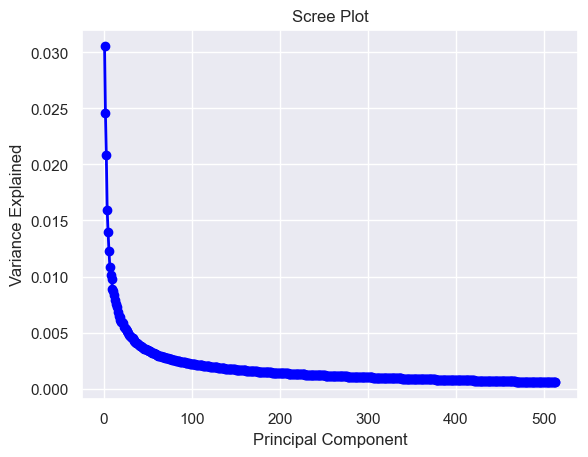

In [33]:
# make a scree plot to visualize the PCA results

PC_values = np.arange(pca2.n_components_) + 1
plt.plot(PC_values, pca2.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [34]:
# apply pca to training and test set
X_train_pca = pca2.fit_transform(X_train)
X_test_pca = pca2.transform(X_test)

Individual predictors explained very little variance and even after running the PCA a high number of predictors remained. Nevertheless, we reduced the number considerably compared to the baseline model.

### Model 2.a. Baseline Parameters

First, we fit a random forest classifier with the reduced number of predictors and the default parameter settings. We used 5-fold cross validation and the out-of-the-bag (OOB) score to evaluate performance of this baseline model.

In [35]:
# Initialize basic rf
rf_pca = RandomForestClassifier(oob_score=True)
rf_pca.fit(X_train_pca, y_train)
rf_pca_cross_val = cross_val_score(rf_pca, X_train_pca, y_train, cv=5)

rf_pca_cross_val_pred = cross_val_predict(rf_pca, X_train_pca, y_train, cv=5) # für confusion matrix
matrix_pred_pca = confusion_matrix(y_train, rf_pca_cross_val_pred)
matrix_pred_pca = matrix_pred_pca.astype('float') / matrix_pred_pca.sum(axis=1)[:, np.newaxis]

In [36]:
print(f"This model has an OOB score of {rf_pca.oob_score_}")
print(f"The mean cross validation score was {rf_pca_cross_val.mean()}")
print(f"The standard deviation of our cross validation was {rf_pca_cross_val.std()}")

This model has an OOB score of 0.56957928802589
The mean cross validation score was 0.5323891948596905
The standard deviation of our cross validation was 0.04347751074262421


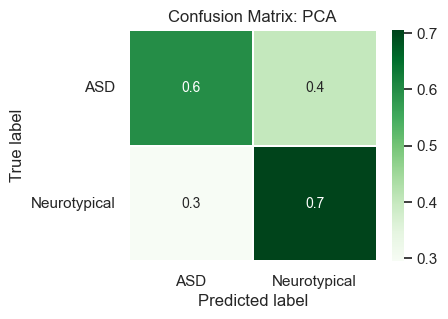

In [42]:
# plot the cunfusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(matrix_pred_pca, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: PCA')

plt.show()

### Model 2.b. Hyperparameter Tuning

Next, we try to improve the model again by finding the best parameters settings. As we were able to achieve higher accuracy than within our baseline model, we discarded the baseline model. Thus, for Model 2, we only fit Model 2.b. to the test dataset.

In [ ]:
# random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random_pca = RandomizedSearchCV(estimator = rf_pca, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
rf_random_pca.fit(X_train_pca, y_train)

random_pca_results = pd.DataFrame(rf_random_pca.cv_results_) # "accuracy" and training score
print(f"Best parameters for the PCA model: {rf_random_pca.best_params_}") # parameter setting that gave the best results on the hold out data
print(f"Best training score: {rf_random_pca.best_score_}")

In [46]:
# fit the model with the best paramaters
rf_pca_bestpars = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_features = 0.25, max_depth = 5, bootstrap = False)
rf_pca_bestpars.fit(X_train_pca, y_train)

# five folds of cross validation
rf_cross_val_pred_pca_bestpars = cross_val_predict(rf_pca_bestpars, X_train, y_train, cv=5) # für prediction für matrix
rf_cross_val_score_pca_bestpars = cross_val_score(rf_pca_bestpars, X_train, y_train, cv=5)
matrix_pred_pca_bestpars = confusion_matrix(y_train, rf_cross_val_pred_pca_bestpars)
matrix_pred_pca_bestpars = matrix_pred_pca_bestpars.astype('float') / matrix_pred_pca_bestpars.sum(axis=1)[:, np.newaxis]

print(f"The mean cross validation score was {rf_cross_val_score_pca_bestpars.mean()}")
print(f"The standard deviation of our cross validation was {rf_cross_val_score_pca_bestpars.std()}")

The mean cross validation score was 0.6732231838447416
The standard deviation of our cross validation was 0.045226074180404675


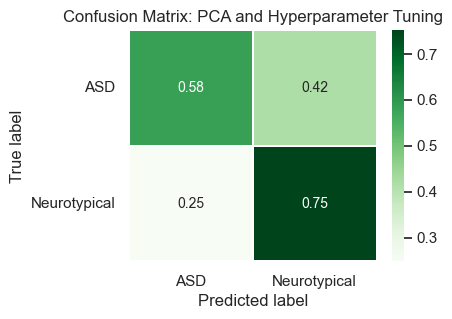

In [65]:
# plot the confusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(matrix_pred_pca_bestpars, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: PCA and Hyperparameter Tuning')

plt.show()

In [49]:
# Fit model to test data
y_pred_pca_bestpars = rf_pca_bestpars.predict(X_test_pca)

## Model 3: Graph Theory - Betweenness Centrality and Degree

To employ a dimensionality reduction innate to functional connectivity data, with Model 3, we decided to focus on the connections each ROI has to other ROI using graph theoretical measures. In a graph theoretical analysis, degree of a "node" (ROI) refers to the number of "edges" (connections) a node has. Betweenness centrality is a centrality measure that refers to the number of shortest paths that pass through a specific node (Garrison et al., 2015). Although other graph theoretical measures such as global efficiency and clustering coefficient might also be of interest for our classification attempt, we decided to restrain our analysis due to time constraints.

We decided to look at two models: (a) a model which binarizes functional connectivity based on proportional thresholds and uses these to calculate betweenness centrality, and (b) a model which uses the “raw” correlations to calculate the degree. Albeit many graph theoretical measures cannot be calculated without binarization, this is not the case for the degree of a node. As the choice of threshold can be an issue in graph theoretical analyses especially when looking at clinical populations, we circumvent this in the second part of Model 3 by avoiding binarization.

As both models had subpar prediction accuracies and we did not have time left for hyperparameter tuning, we decided against fitting them to our test data.

### Prepare Data

In [230]:
# Create class "GraphTheoryBetweenness" to calculate betweenness centrality.
# The idea is to first calculate the connectivity matrix and then based on this,
# continue with the betweenness centrality.
class GraphTheoryBetweenness:
    '''
        Parameters:
            - time_course_path: path to a 1D file containing timecourses of all relevant regions
              for one specific subject
            - correlation_kind: {"covariance", "correlation", "partial correlation", "tangent", "precision"}, 
              default="correlation"
              Kind of correlation to calcualte, takes same arguments as nilearn.connectome.ConnectivityMeasure()
            - thresh_percentile: int or list of ints for percentile(s) at which matrix is thresholded, default = 80
            - subject_ID: whether "FILE_ID" should be added to dict, default = True

        Returns: 
            - bet_cent_dict: Dictionnary with betweenness centrality for all ROIs and subject ID as key "FILE_ID"
    '''
    
    def __init__(self, thresh_percentile, correlation_kind, time_course_path, subject_ID=True):

        self.thresh_percentile = thresh_percentile
        self.correlation_kind = correlation_kind
        self.time_course_path = time_course_path
        self.subject_ID = subject_ID
        
    def corr_matrix(self):
        '''
        This function calculates a correlation matrix based on a 1D timeseries file.     
        
            Returns:
                - correlation_matrix: A correlation matrix in form of a 2D array 
        '''

        # Read in time courses as a dataframe
        timecourse_df = pd.read_csv(self.time_course_path, sep="\t")

        # Instantiate nilearn connectivity measure object
        correlation_measure  = connectome.ConnectivityMeasure(kind=self.correlation_kind)

        # Calculate partical correlations
        correlation_matrix = correlation_measure.fit_transform(
            np.array([timecourse_df]))[0]
    
        return(correlation_matrix)


    # A function that calculates betweenness centrality for a single subject
    def calculate_bet_centrality(self, subject_ID=True):
        '''
        This function calculates betweenness centrality for each ROI contained in
        a correlation matrix.
        
            Returns:
                - bet_cent: A dictionnary containing the betweenness centrality value for each ROI
        '''

        if type(self.thresh_percentile) == list:

            thresh_list = []

            for thresh_perc in self.thresh_percentile:

                # Define proportional threshold
                thresh = np.nanpercentile(self.corr_matrix(), thresh_perc)
            
                # Set edges to 1 or 0 depending on threshold
                mean_matrix_thresh = self.corr_matrix().copy()
                mean_matrix_thresh[mean_matrix_thresh < thresh] = 0
                mean_matrix_thresh[mean_matrix_thresh >= thresh] = 1
            
                # Create Graph
                G = nx.from_numpy_array(mean_matrix_thresh)
            
                # Calculate betweenness centrality
                bet_cent_thresh = nx.betweenness_centrality(G)

                thresh_list.append(bet_cent_thresh)
            
            bet_cent = dict(np.mean(pd.DataFrame(thresh_list), axis = 0))
            
        
        else:    
        
            # Define proportional threshold
            thresh = np.nanpercentile(self.corr_matrix(), self.thresh_percentile)
        
            # Set edges to 1 or 0 depending on threshold
            mean_matrix_thresh = self.corr_matrix().copy()
            mean_matrix_thresh[mean_matrix_thresh < thresh] = 0
            mean_matrix_thresh[mean_matrix_thresh >= thresh] = 1
        
            # Create Graph
            G = nx.from_numpy_array(mean_matrix_thresh)
        
            # Calculaate betweenness centrality
            bet_cent = nx.betweenness_centrality(G)
    
        if self.subject_ID:
            # Get "FILE_ID" from path and add it to dict
            subject_id = self.time_course_path.split("\\")[-1].split("_rois")[0]
            bet_cent["FILE_ID"] = subject_id   
            return(bet_cent)
        
        else:
            return(bet_cent)


In [ ]:
# Here, we calculate betweenness centrality for all ROIs for all subjects

# Define thresholds we want to use
thresh_steps = np.arange(70, 91, 2).tolist()

# Create empty list
subj_dict_list = []

# Add dict for each subject to list
for path in subj_paths:
    graph_measure = GraphTheoryBetweenness(thresh_steps, "partial correlation", path) 
    subj_dict_list.append(graph_measure.calculate_bet_centrality())

# From list of dicts, create dataframe
graph_df = pd.DataFrame(subj_dict_list)

In [ ]:
# This is our binarized betweenness centrality dataframe
graph_df

In [203]:
graph_df.to_csv("graph_df.csv", index = False)

In [73]:
class CalculateDegree:
    def __init__(self, time_course_path, correlation_kind="partial correlation", subject_ID=True):
        '''          
         Parameters:
            - time_course_path: path to a 1D file containing timecourses of all relevant regions
              for one specific subject
            - correlation_kind: {"covariance", "correlation", "partial correlation", "tangent", "precision"}, 
              default="partial correlation"
              Kind of correlation to calcualte, takes same arguments as nilearn.connectome.ConnectivityMeasure()
            - subject_ID: whether "FILE_ID" should be added to dict, default = True

        Returns: 
            - degree_dict: Dictionnary with degree for all ROIs and subject ID as key "FILE_ID"
        '''
        self.time_course_path = time_course_path
        self.correlation_kind = correlation_kind
        self.subject_ID = subject_ID
        
    def get_correlations(self):
        
        df = pd.read_csv(self.time_course_path, sep="\t")
        df = np.array(df)
        
        # calculate corr matrix for DataFrame (all rois)
        correlation_measure = connectome.ConnectivityMeasure(
            kind=self.correlation_kind
        )
        connectivity_matrix = correlation_measure.fit_transform([df])[0]

        # transform into dataframe for easier handling
        corrs = pd.DataFrame(connectivity_matrix)
        
        return(corrs)

    def get_degree(self):

        df_corr = self.get_correlations()
        degree_dict = {}

        # calculate degree for each individual roi. Minus 1 to subtract correlation with itself.
        for i in range(len(df_corr)):
            degree_dict[i] = df_corr.iloc[i,:].sum() - 1

        # if wanted, add subject ID in form of FILE_ID to dict
        if self.subject_ID==True:
            subject_id = self.time_course_path.split("\\")[-1].split("_rois")[0]
            degree_dict["FILE_ID"] = subject_id 

        return(degree_dict)

In [69]:
# Calculate all degrees for all subjects
degree_dicts = []
for path in subj_paths:
    degree_calc = CalculateDegree(path)
    degree_dicts.append(degree_calc.get_degree())

degree_df = pd.DataFrame(degree_dicts)

In [74]:
# better save than sorry
degree_df.to_csv("degree_df.csv")

### Model 3.a. Betweenness Centrality

As the choice of proportional threshold can sometimes be achieved in a somewhat arbitrary manner, we attempted to obtain a more stable estimate by calculating the mean betweenness centrality based on proportional thresholds between percentile 70 and 90 in steps of 2.

In [207]:
# We merge our graph theory measure df and the diagnosis df on file id
graph_merged_df = pd.merge(graph_df, diagnose_df, on = "FILE_ID", how = "left")
graph_merged_df = graph_merged_df.dropna()

In [208]:
# We split our data in predictors and outcome
X = graph_merged_df.drop(["FILE_ID", "DX_GROUP", "DSM_IV_TR"], axis=1)
y = graph_merged_df["DX_GROUP"]

# We split our aata into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [213]:
# Initialize basic rf
rf = RandomForestClassifier(oob_score=True)

rf.fit(X_train, y_train)
rf_cross_val = cross_val_score(rf, X_train, y_train, cv=5)

In [214]:
print(f"This model has an OOB score of {rf.oob_score_}")
print(f"The mean cross validation score was {rf_cross_val.mean()}")
print(f"The standard deviation of our cross validation was {rf_cross_val.std()}")

This model has an OOB score of 0.5226537216828478
The mean cross validation score was 0.5371754523996853
The standard deviation of our cross validation was 0.03495660489716523


### Model 3.b. Degree

We calculated the degree for each ROI using both negative and positive correlations.

In [78]:
# We merge our degree df and the diagnosis df on file id
degree_merged_df = pd.merge(degree_df, diagnose_df, on = "FILE_ID", how = "left")
degree_merged_df = degree_merged_df.dropna()

In [79]:
# We split our data in predictors and outcome
X = degree_merged_df.drop(["FILE_ID", "DX_GROUP", "DSM_IV_TR"], axis=1)
y = degree_merged_df["DX_GROUP"]

# We split our aata into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [80]:
# Initialize basic rf
rf_degree = RandomForestClassifier(oob_score=True)

rf_degree = rf_degree.fit(X_train, y_train)
rf_degree_cross_val = cross_val_score(rf_degree, X_train, y_train, cv=5)

In [83]:
print(f"This model has an OOB score of {rf_degree.oob_score_}")
print(f"The mean cross validation score was {rf_degree_cross_val.mean()}")
print(f"The standard deviation of our cross validation was {rf_degree_cross_val.std()}")

This model has an OOB score of 0.5339805825242718
The mean cross validation score was 0.503147128245476
The standard deviation of our cross validation was 0.04227714267344581


## Performance on Test Data

### Model 1.b. - Hyperparameter tuned, all predictors

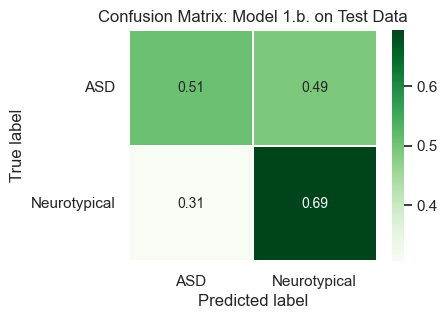

Classification
              precision    recall  f1-score   support

           1       0.55      0.51      0.53       112
           2       0.66      0.69      0.68       154

    accuracy                           0.62       266
   macro avg       0.60      0.60      0.60       266
weighted avg       0.61      0.62      0.61       266

Accuracy
0.6165413533834586


In [59]:
# Evaluate model

# Create confusion matrix
test_confusion_all_preds = confusion_matrix(y_test, y_pred_bestpars)
test_confusion_all_preds = test_confusion_all_preds.astype('float') / test_confusion_all_preds.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(test_confusion_all_preds, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: Model 1.b. on Test Data')

plt.show()

print("Classification")
print(classification_report(y_test, y_pred_bestpars))
print("Accuracy")
print(accuracy_score(y_test, y_pred_bestpars))

### Model 2.b. - Hyperparameter tuned, PCA

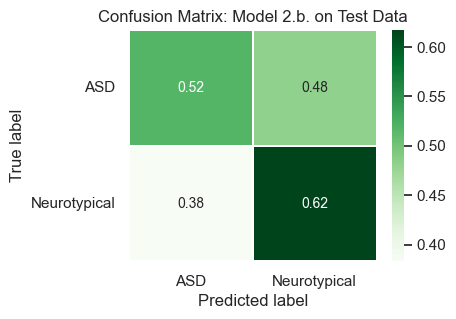

Classification
              precision    recall  f1-score   support

           1       0.50      0.52      0.51       112
           2       0.64      0.62      0.63       154

    accuracy                           0.58       266
   macro avg       0.57      0.57      0.57       266
weighted avg       0.58      0.58      0.58       266

Accuracy
0.575187969924812


In [61]:
# Evaluate model

# Create confusion matrix
test_confusion_pca = confusion_matrix(y_test, y_pred_pca_bestpars)
test_confusion_pca = test_confusion_pca.astype('float') / test_confusion_pca.sum(axis=1)[:, np.newaxis]

# plot the confusion matrix
# build the plot
plt.figure(figsize=(4,3))
sns.set(font_scale=1)
sns.heatmap(test_confusion_pca, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# add labels to the plot
class_names = ['ASD', 'Neurotypical']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix: Model 2.b. on Test Data')

plt.show()

print("Classification")
print(classification_report(y_test, y_pred_pca_bestpars))
print("Accuracy")
print(accuracy_score(y_test, y_pred_pca_bestpars))

## Discussion
We were able to predict ASD diagnosis in the test data with 57.5% accuracy using PCA and 61.7% accuracy without any dimensionality reduction. While this points to some alterations in functional connectivity between people with ASD and neurotypicals, these results cannot be interpreted in favor of using functional connectivity as a diagnostic tool for ASD. We left several avenues unexplored, which may constitute starting points for more comprehensive analyses and comparisons to obtain both higher classification accuracies but also inferences about the neural correlates of ASD. Firstly, ASD is a spectrum, therefore, random forest regressors using test scores either as a continuous outcome or to only include individuals with very high and very low scores may fare better. Secondly, disorder-specific stimuli and task-based designs might offer more insights if looking for means to diagnose. One could also attempt to identify specific activity patterns distinct to people with ASD in response to these stimuli, and perhaps even test whether they emerge spontaneously in resting-state data. Thirdly, focussing only on regions and networks implicated in ASD but using a finer parcellation might offer a reduction in dimensionality while retaining more relevant information. Lastly, different graph theoretical measures could be explored, and different thresholding choices compared, which might offer additional insights not only for ASD but also for applications of graph theory to functional connectivity data.

## References: 

Chen, C. P., Keown, C. L., Jahedi, A., Nair, A., Pflieger, M. E., Bailey, B. A. & Müller, R. (2015). Diagnostic classification of intrinsic functional connectivity highlights somatosensory, default mode, and visual regions in autism. NeuroImage. Clinical, 8, 238–245. https://doi.org/10.1016/j.nicl.2015.04.002

Craddock, R. C., Benhajali, B., Chu, C., Chouinard, C., Evans, E., Jakab, J., Khundrakpam, K., Lewis, L., Li, L., Milham, M., Yan, Y. & Bellec, B. (2013). The Neuro Bureau Preprocessing Initiative: open sharing of preprocessed neuroimaging data and derivatives. *Frontiers in Neuroinformatics, 7*. https://doi.org/10.3389/conf.fninf.2013.09.00041

Craddock, R. C., James, G., Holtzheimer, P. E., Hu, X. P. & Mayberg, H. S. (2011). A whole brain fMRI atlas generated via spatially constrained spectral clustering. *Human Brain Mapping, 33*(8), 1914–1928. https://doi.org/10.1002/hbm.21333

Garrison, K. A., Scheinost, D., Finn, E. S., Shen, X. & Constable, R. T. (2015). The (in)stability of functional brain network measures across thresholds. *NeuroImage, 118*, 651–661. https://doi.org/10.1016/j.neuroimage.2015.05.046

Heinsfeld, A. S., Franco, A. R., Craddock, R. C., Buchweitz, A. & Meneguzzi, F. (2018). Identification of autism spectrum disorder using deep learning and the ABIDE dataset. *NeuroImage: Clinical, 17*, 16–23. https://doi.org/10.1016/j.nicl.2017.08.017

Ilioska, I., Oldehinkel, M., Llera, A., Chopra, S., Looden, T., Chauvin, R., Van Rooij, D., Floris, D. L., Tillmann, J., Moessnang, C., Banaschewski, T., Holt, R. J., Loth, E., Charman, T., Murphy, D. G., Ecker, C., Mennes, M., Beckmann, C. F., Fornito, A. & Buitelaar, J. K. (2023). Connectome-wide Mega-analysis Reveals Robust Patterns of Atypical Functional Connectivity in Autism. *Biological Psychiatry, 94*(1), 29–39. https://doi.org/10.1016/j.biopsych.2022.12.018

Lord, C., Brugha, T. S., Charman, T., Cusack, J., Dumas, G., Frazier, T., Jones, E. J. H., Jones, R. M., Pickles, A., State, M. W., Taylor, J. L. & Veenstra-VanderWeele, J. (2020). Autism spectrum disorder. *Nature Reviews. Disease Primers, 6*(1). https://doi.org/10.1038/s41572-019-0138-4 

Yang, X., T., P., & Zhang, N. (2020). A deep neural network study of the ABIDE repository on autism spectrum classification. *International Journal of Advanced Computer Science and Applications, 11*(4). https://doi.org/10.14569/IJACSA.2020.0110401

Yang, X., Zhang, N. & Schrader, P. (2022). A study of brain networks for autism spectrum disorder classification using resting-state functional connectivity. *Machine Learning With Applications, 8*, 100290. https://doi.org/10.1016/j.mlwa.2022.100290